## Question C: Neural Network ##

### Load Dataset and preprocess data ###

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# one hot encoding
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

py.init_notebook_mode(connected=True)

features = ['Week', 'DayOfWeek','BackupStartTime', 'WorkFlowID', 'Filename','SizeOfBackup','BackupTime']
weekdays = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df = pd.read_csv('./network_backup_dataset.csv', names = features, header = 0)
df.drop(6)
training_label = np.asarray(df['SizeOfBackup'].values, dtype=np.float)

def encode_day_names(days):
    res = []
    for day in days:
        res.append(weekdays[day])
    return res

def encode_files(files):
    res = []
    for file in files:
        a,b = file.split('_')
        res.append(int(b))
    return res

def encode_work_flows(work_flows):
    res = []
    for wf in work_flows:
        a,b,c = wf.split('_')
        res.append(int(c))
    return res

X = df.ix[:, [0, 1, 2, 3, 4]].values
X[:, 1] = encode_day_names(X[:, 1])
X[:, 3] = encode_work_flows(X[:, 3])
X[:, 4] = encode_files(X[:, 4])



### One Hot Encoding to the 5 features ###

In [10]:
training_data = pd.DataFrame(X).astype('float64')
onehot_encoded_data = []
label_encoder = LabelEncoder()
integer_encoded = training_data.apply(label_encoder.fit_transform)
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
scaler = StandardScaler()
standard_data = scaler.fit_transform(onehot_encoded_data)

### Plot the fitted values against true values and residual values ###

In [4]:
def two_plots_revised(allpre_res, pre_gt):
    x = np.arange(0, 1000)
    y1 = allpre_res
    y2 = pre_gt
    residual = []
    for i in range(0, len(allpre_res)):
        residual.append(allpre_res[i]-pre_gt[i])
    # residual = pre_gt - allpre_res
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

### Build Model and sweep the parameters ###

In [7]:
# print onehot_encoded_data
# Number of hidden units
# Activity Function(relu, logistic, tanh)
activation = ['relu', 'logistic', 'tanh']
lineStyle = [dict(color='blue', dash = 'dash', width=2), dict(color=('rgb(255, 218, 0)'), dash = 'dash', width=2),dict(color=('rgb(177, 228, 0)'), width=2), dict(color=('rgb(91, 116, 0)'), width=2),
             dict(color=('rgb(81, 147, 245)'), dash='dot', width=2), dict(color=('rgb(158, 135, 176)'), dash = 'dot', width=2)]
folds = 10
rmse_train = []
rmse_test = []
rmse_plot_train = []
rmse_plot_test = []
plot_gd_all = []
plot_test_all = []
rmse_plots = []
data = []
k = 0
min_test = 100
min_act = ""
min_hidden = 0
x_data = range(5,200,10)
for actfunc in activation:
    for layersize in range(5,200,10):
        for rd in range(folds):
            clf = MLPRegressor(hidden_layer_sizes=(layersize),activation=actfunc,solver='lbfgs',max_iter=100,learning_rate_init=0.01,alpha=0.01)
            X_train, X_test, y_train, y_test = train_test_split(standard_data, training_label, train_size=0.9)
            # pipeline = Pipeline([("polynomial_features", polynomial_features), ("Neural_network", clf)])
            pipeline = Pipeline([ ("Neural_network", clf)])
            pipeline.fit(X_train, y_train)
            train_predict = pipeline.predict(X_train)
            test_predict = pipeline.predict(X_test)
            # clf.fit(onehot_encoded_data, training_label)
            # print standard_data.shape
            # print training_label.shape
            rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
        print ('rmse_train: ', np.mean(rmse_train), 'rmse_test:', np.mean(rmse_test), 'layersize:', layersize, 'actfunc: ', actfunc)
        if min_test > np.mean(rmse_test):
            min_test = np.mean(rmse_test)
            min_hidden = layersize
            min_act = actfunc
        rmse_plot_train.append(np.mean(rmse_train))
        rmse_plot_test.append(np.mean(rmse_test))
        # rmse_plot_train.append(np.mean(rmse_train))
        # rmse_plot_test.append(np.mean(rmse_test))
        rmse_train = []
        rmse_test = []
    # plot_func(x_data, rmse_plot_test, '', actfunc, "Test")
    data.append(go.Scatter(x=x_data, y=rmse_plot_train, mode='lines', line=lineStyle[k],name="Train_"+actfunc))
    k+=1
    data.append(go.Scatter(x=x_data, y=rmse_plot_test, mode='lines', line=lineStyle[k], name="Test_" + actfunc))
    k+=1
    rmse_plot_train = []
    rmse_plot_test = []
print("min test rmse: ", min_test,"at hidden layer size: ", min_hidden,"at activity function: ", min_act)
layout = go.Layout(title="Train/Test-RMSE VS number of hidden units for different activity function",
                       autosize=False,
                       width=800,
                       height=600,
                       xaxis=dict(title="Hidden Layer Units", ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title="RMSE", ticks='outside', mirror=True, linewidth=1),legend=dict(x=-.1, y=1.2))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="")

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/ana

rmse_train:  0.08162452732520988 rmse_test: 0.08084286420413493 layersize: 5 actfunc:  relu


/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/ana

rmse_train:  0.08033303434796954 rmse_test: 0.08240194032317012 layersize: 15 actfunc:  relu


/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/Users/yuqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



KeyboardInterrupt: 

### Plot ###

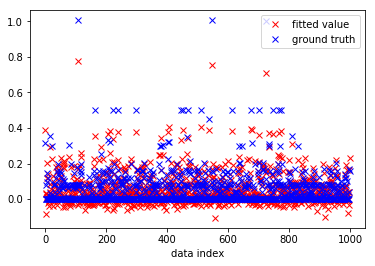

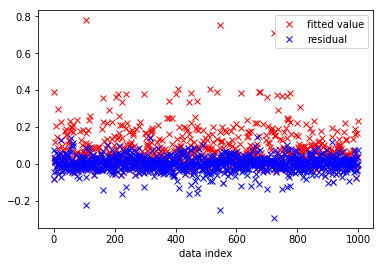

In [5]:
for rd in range(folds):
    clf = MLPRegressor(hidden_layer_sizes=(min_hidden), activation=min_act, solver='lbfgs', max_iter=100,
                       learning_rate_init=0.01, alpha=0.01)
    X_train, X_test, y_train, y_test = train_test_split(standard_data, training_label, train_size=0.9)
    # pipeline = Pipeline([("polynomial_features", polynomial_features), ("Neural_network", clf)])
    pipeline = Pipeline([("Neural_network", clf)])
    pipeline.fit(X_train, y_train)
    train_predict = pipeline.predict(X_train)
    test_predict = pipeline.predict(X_test)
    # clf.fit(onehot_encoded_data, training_label)
    # print standard_data.shape
    # print training_label.shape
    plot_test_all.extend(test_predict)
    plot_gd_all.extend(y_test)
two_plots_revised(plot_test_all, plot_gd_all)

## Question E: k-nearest neighbor regression ##

In [9]:
rmse_plot_train = []
rmse_plot_test = []
rmse_gd = []
plot_gd_all = []
plot_test_all = []
min_test = 100
min_neigh = 0
for neighborsize in range(1, 100):
    for rd in range(folds):
        # polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
        clf = KNeighborsRegressor(n_neighbors=neighborsize)
        X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, train_size=0.9)
        pipeline = Pipeline([ ("KNN", clf)])
        pipeline.fit(X_train, y_train)
        train_predict = pipeline.predict(X_train)
        test_predict = pipeline.predict(X_test)
        # clf.fit(onehot_encoded_data, training_label)
        # print standard_data.shape
        # print training_label.shape
        rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
    print 'rmse_train: ', np.mean(rmse_train), 'rmse_test:', np.mean(rmse_test)
    if min_test > np.mean(rmse_test):
        min_test = np.mean(rmse_test)
        min_neigh = neighborsize
    rmse_plot_train.append(np.mean(rmse_train))
    rmse_plot_test.append(np.mean(rmse_test))
    rmse_train = []
    rmse_test = []
print "min test rmse: ", min_test, "at neighbour size: ", min_neigh

rmse_train:  0.00391003816511 rmse_test: 0.0537566529292
rmse_train:  0.0299477860248 rmse_test: 0.0438791727566
rmse_train:  0.0292545589185 rmse_test: 0.0377947528017
rmse_train:  0.0281207923048 rmse_test: 0.0351376056847
rmse_train:  0.0272430616659 rmse_test: 0.0346126027682
rmse_train:  0.0292920222143 rmse_test: 0.0392076266989
rmse_train:  0.0336767894999 rmse_test: 0.0449569635556
rmse_train:  0.0372628102325 rmse_test: 0.0426019181927
rmse_train:  0.0397298960583 rmse_test: 0.045998471875
rmse_train:  0.0419333945806 rmse_test: 0.0479943997886
rmse_train:  0.0439828010749 rmse_test: 0.0496515880222
rmse_train:  0.0453723784787 rmse_test: 0.0507656497687
rmse_train:  0.046697423222 rmse_test: 0.0540100295296
rmse_train:  0.0485098710896 rmse_test: 0.0546386795106
rmse_train:  0.0498567350233 rmse_test: 0.0541878312427
rmse_train:  0.0513181800643 rmse_test: 0.0520541622141
rmse_train:  0.0517624992955 rmse_test: 0.0533542380571
rmse_train:  0.0517956207775 rmse_test: 0.0536550

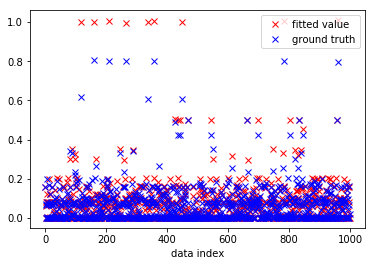

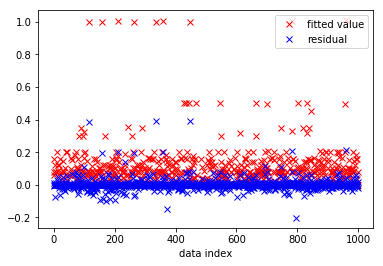

In [10]:
for rd in range(folds):
    # polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    clf = KNeighborsRegressor(n_neighbors=min_neigh)
    X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, train_size=0.9)
    pipeline = Pipeline([("KNN", clf)])
    pipeline.fit(X_train, y_train)
    train_predict = pipeline.predict(X_train)
    test_predict = pipeline.predict(X_test)
    # clf.fit(onehot_encoded_data, training_label)
    # print standard_data.shape
    # print training_label.shape
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predict)))
    plot_gd_all.extend(test_predict)
    plot_test_all.extend(y_test)

two_plots_revised(plot_test_all, plot_gd_all)

In [11]:
data = []
x_data = range(50, 151)
data.append(go.Scatter(x=x_data, y=rmse_plot_train, mode='lines', line=lineStyle[0],name="Train_"+"KNN"))
data.append(go.Scatter(x=x_data, y=rmse_plot_test, mode='lines', line=lineStyle[1],name="Test_"+"KNN"))
ayout = go.Layout(title="Train/Test-RMSE VS number of Neighbors for KNN",
                       autosize=False,
                       width=800,
                       height=600,
                       xaxis=dict(title="Num of neighbours", ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title="RMSE", ticks='outside', mirror=True, linewidth=1),
                       legend=dict(x=.5, y=.2, bordercolor='#D3D3D3', borderwidth=1))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="")